<a href="https://colab.research.google.com/github/ToobaFayyaz55/Age-and-Gender-Prediction/blob/main/Age_and_Gender_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'utkface-new:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F44109%2F78156%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240402%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240402T193551Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9fbadf3751bcc2eaca5dda4456a2440fa85aa9f8a38950b7ff4639ac20759233e33ffd8a23e8306a7ee0d7a771413c1fa72f92db1c675327b30b5416031a21dfe13c1fef3113b811b0d0e08d89549e1c86427c96a67065312b9fddb0a1241c16aae9f5984bc26c6283e0311d740ed31c0ef52697d48e111a93a1fb774229667c333fedd6851a3d4e94c215ed07ef13b26dfb033b1d006e2533318c3f32befdab6ae56bd72b00bfb97d790f1a5e6387ad4b6016375cc027f5ea87a5a493f15b4635d7c9947424145ffe976f279af48bd08375868964dfd823943bbef1396f93e4d7621a6093a86fbde09e85f91addb37e9dd7beb4653ef4cd98b422979848bb88'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 347342542 bytes downloaded
Downloaded and uncompressed: utkface-new
Data source import complete.


## Import Modules

In [4]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from google.colab import files
from PIL import Image

## Load the Dataset

In [5]:
BASE_DIR = '/kaggle/input/utkface-new/UTKFace/'

In [6]:
# labels age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [7]:
# CONVERT TO DATAFRAME
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

image  age  gender
0  /kaggle/input/utkface-new/UTKFace/24_1_0_20170...   24       1
1  /kaggle/input/utkface-new/UTKFace/25_0_1_20170...   25       0
2  /kaggle/input/utkface-new/UTKFace/4_0_4_201612...    4       0
3  /kaggle/input/utkface-new/UTKFace/28_0_0_20170...   28       0
4  /kaggle/input/utkface-new/UTKFace/35_0_1_20170...   35       0

In [8]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

## Exploratory Data Analysis

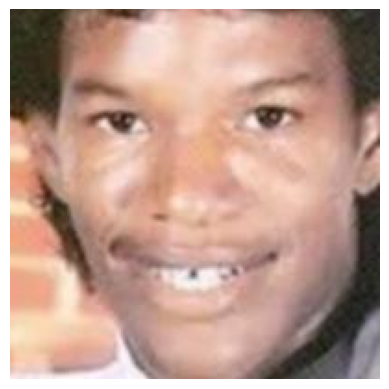

In [9]:
from PIL import Image
img = Image.open(df['image'][1])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

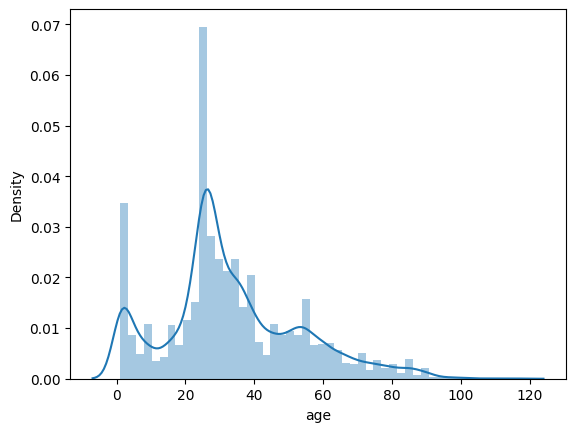

In [10]:
sns.distplot(df['age'])

<Axes: xlabel='gender', ylabel='count'>

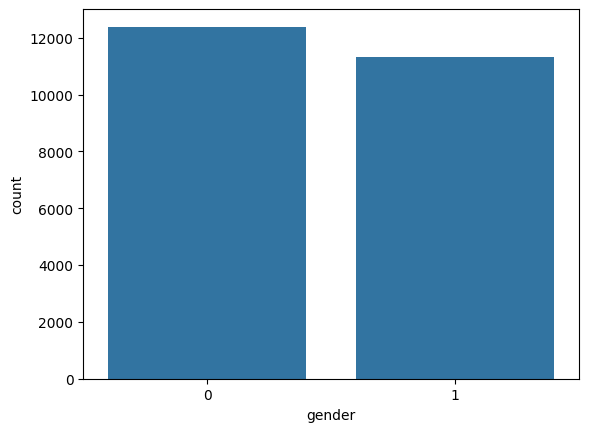

In [11]:
sns.countplot(x='gender', data=df)

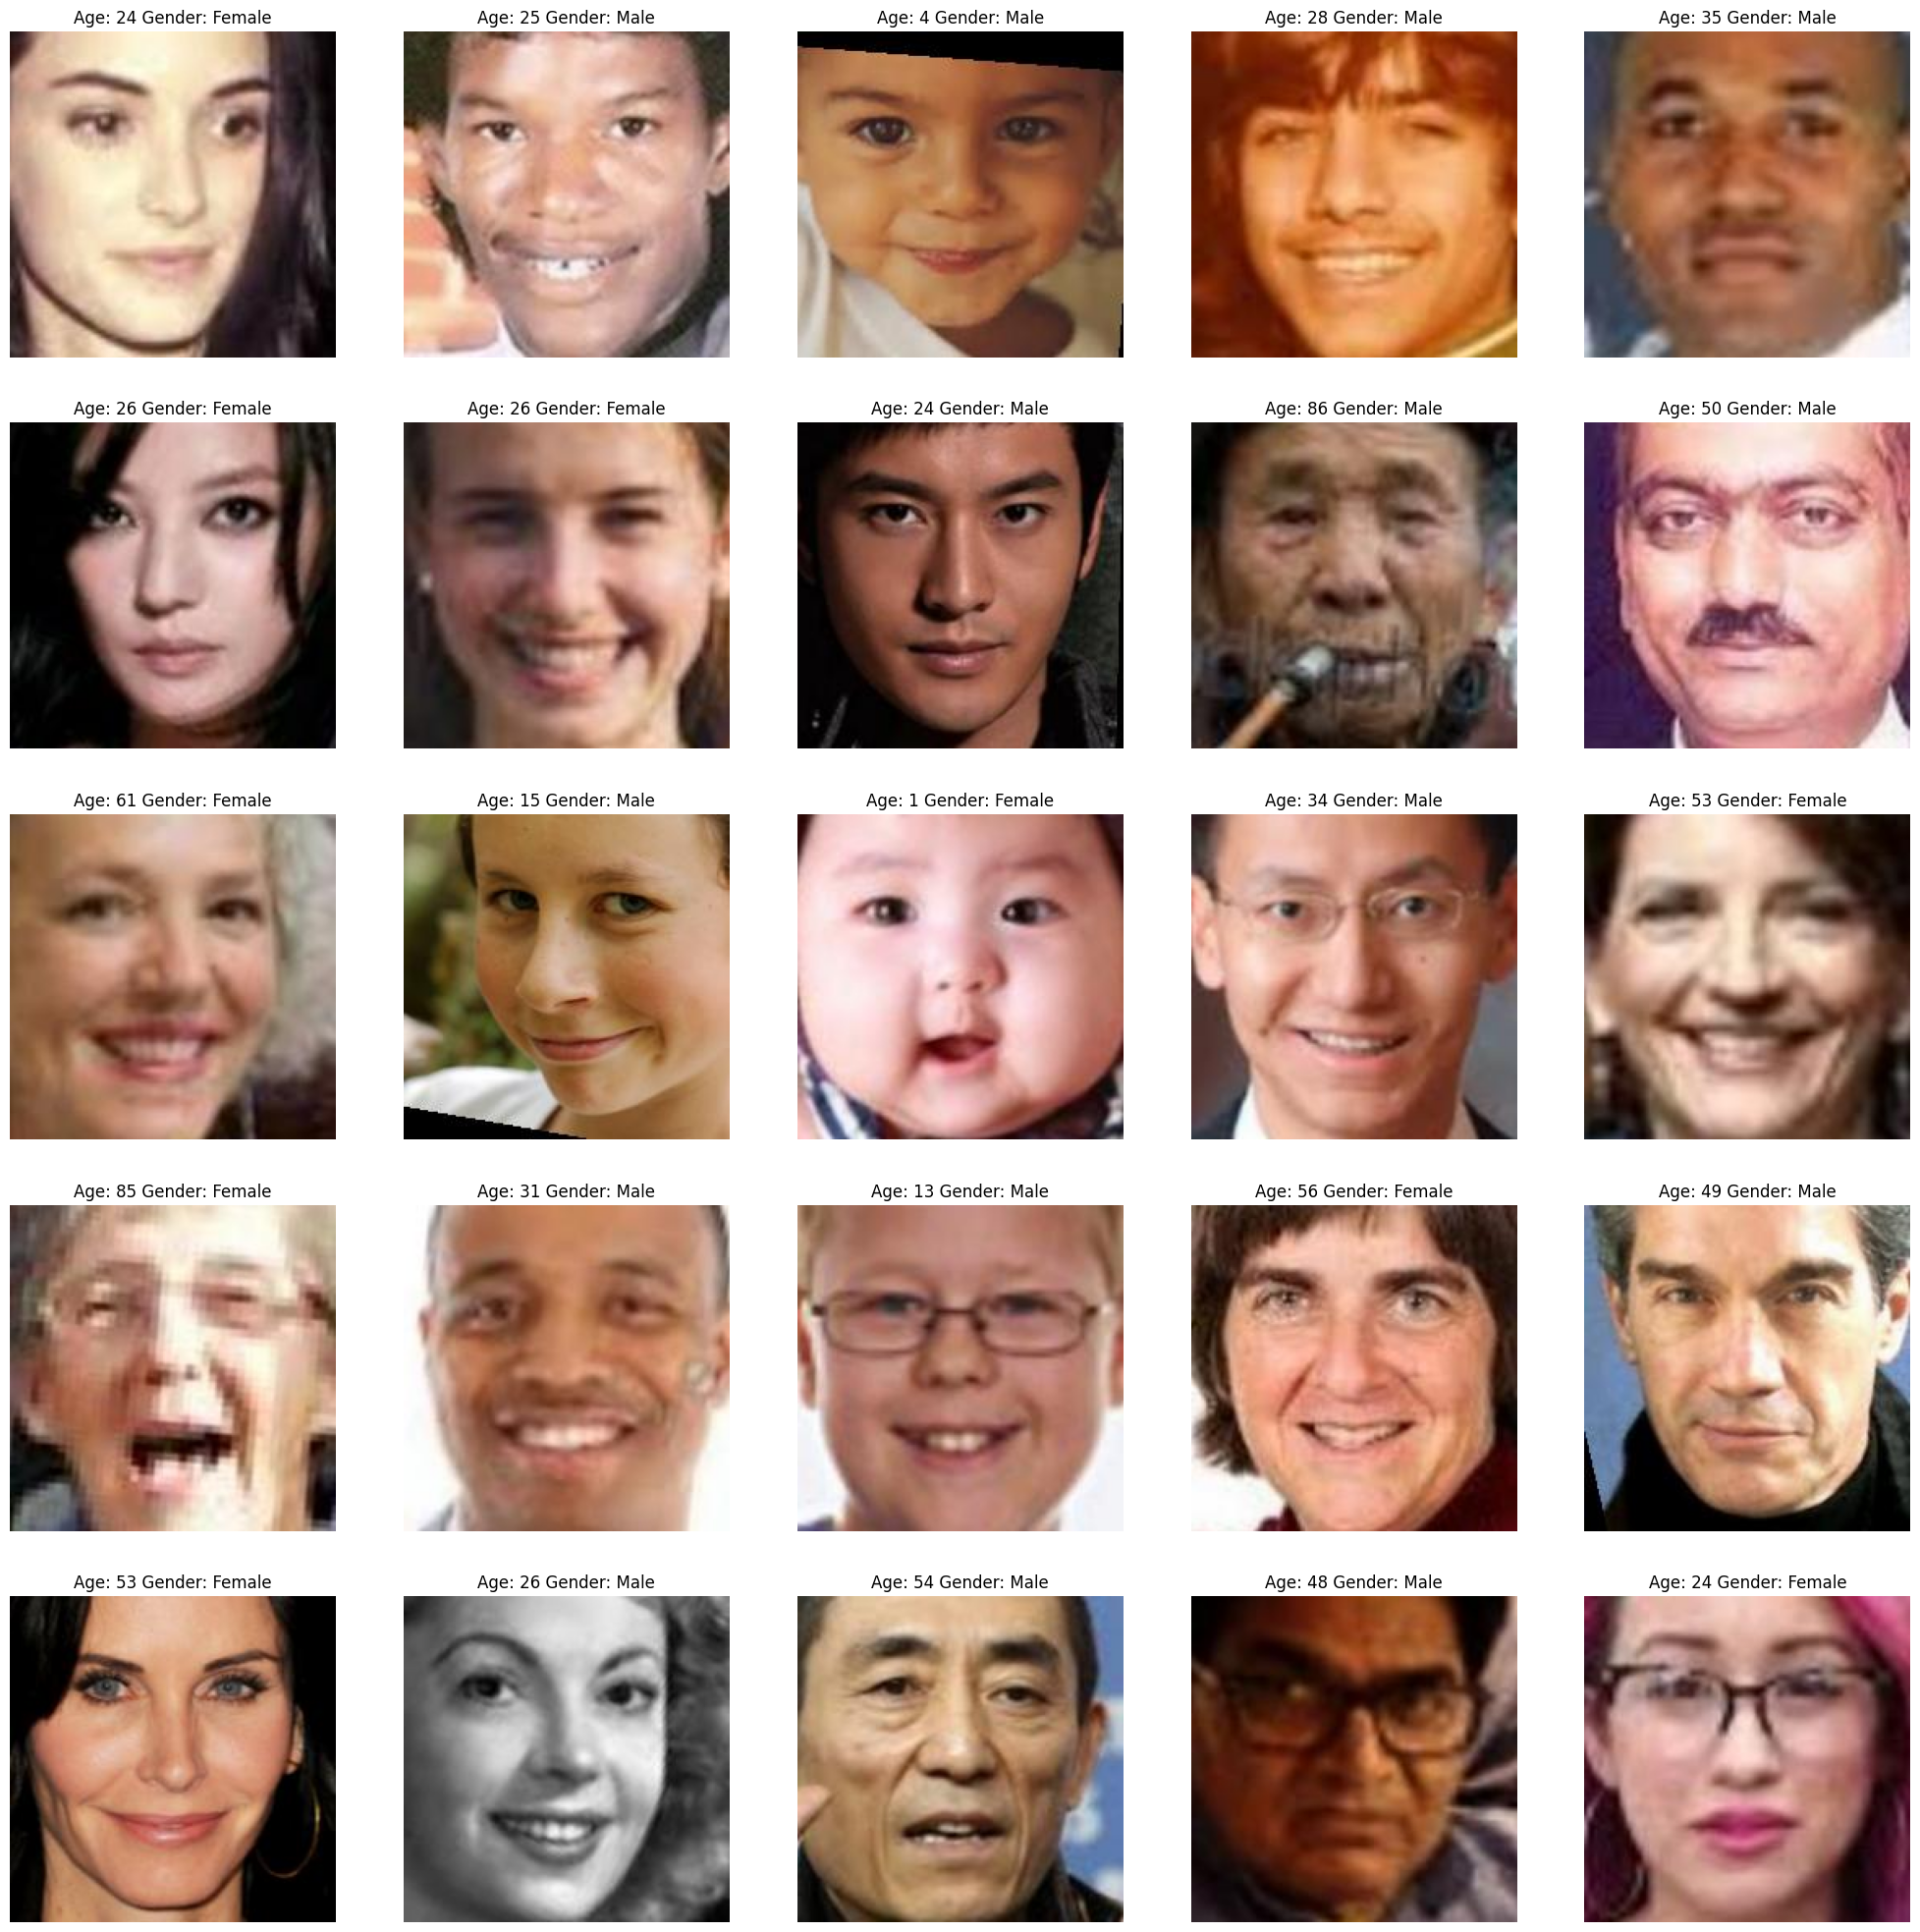

In [12]:
# to display grid of images
plt.figure(figsize=(25, 25))
files = df.iloc[0:25]
for index, file, age, gender in files.itertuples():
  plt.subplot(5, 5, index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title(f'Age: {age} Gender: {gender_dict[gender]}')
  plt.axis('off')

## Feature Extraction

In [13]:
def extract_features(images):
  features = []
  for image in tqdm(images):
    img = load_img(image, grayscale=True)
    img = img.resize((128, 128), Image.ANTIALIAS)
    img = np.array(img)
    features.append(img)

  features = np.array(features)
  features = features.reshape(len(features), 128, 128, 1)
  return features

In [14]:
x = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [15]:
x.shape

(23708, 128, 128, 1)

In [16]:
# normalize the image
x = x / 255.0

In [17]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [18]:
input_shape = (128, 128, 1)

## Model Creation

In [19]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2,2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2,2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2,2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2,2)) (conv_4)
flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation = 'relu') (flatten)
dropout_1 = Dropout(0.3) (dense_1)

dense_2 = Dense(256, activation = 'relu') (dropout_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

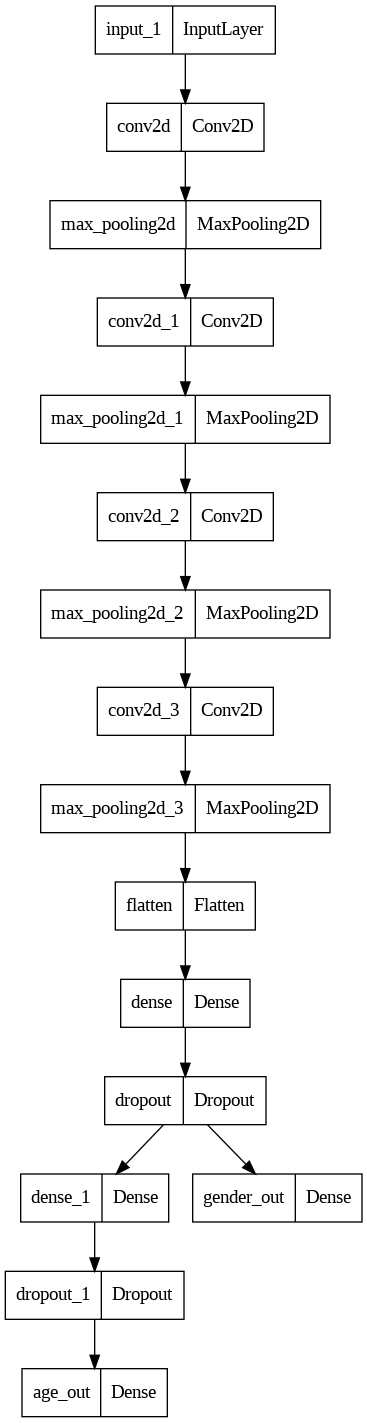

In [20]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [21]:
# train model
history = model.fit(x=x, y=[y_gender, y_age], batch_size=32, epochs=40,
validation_split=0.2)

Epoch 1/40
593/593 [==============================] - 23s 24ms/step - loss: 15.4528 - gender_out_loss: 0.7007 - age_out_loss: 14.7522 - gender_out_accuracy: 0.5934 - gender_out_mae: 0.4472 - age_out_accuracy: 0.0480 - age_out_mae: 14.7522 - val_loss: 11.7537 - val_gender_out_loss: 0.5266 - val_age_out_loss: 11.2270 - val_gender_out_accuracy: 0.7322 - val_gender_out_mae: 0.3638 - val_age_out_accuracy: 0.0445 - val_age_out_mae: 11.2270
Epoch 2/40
593/593 [==============================] - 12s 20ms/step - loss: 11.5353 - gender_out_loss: 0.5491 - age_out_loss: 10.9862 - gender_out_accuracy: 0.7268 - gender_out_mae: 0.3689 - age_out_accuracy: 0.0481 - age_out_mae: 10.9862 - val_loss: 10.3100 - val_gender_out_loss: 0.5016 - val_age_out_loss: 9.8083 - val_gender_out_accuracy: 0.7531 - val_gender_out_mae: 0.3538 - val_age_out_accuracy: 0.0445 - val_age_out_mae: 9.8083
Epoch 3/40
593/593 [==============================] - 12s 20ms/step - loss: 9.9886 - gender_out_loss: 0.4992 - age_out_loss: 9

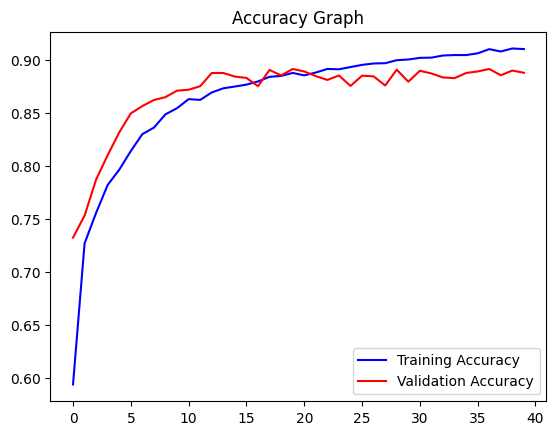

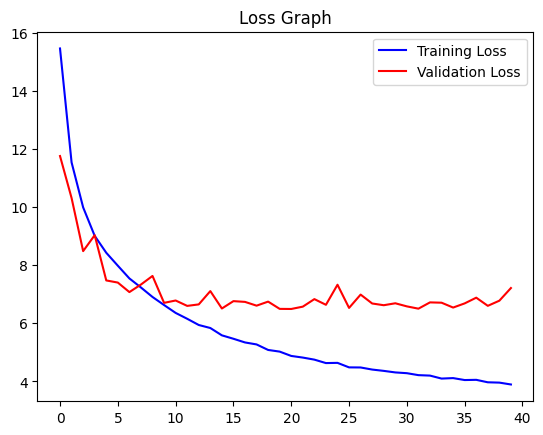

In [27]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

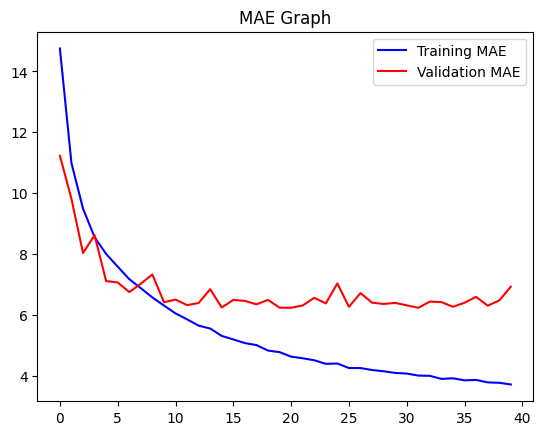

In [28]:
# plot results for age
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('MAE Graph')
plt.legend()
plt.show()

In [22]:
# Save the trained model to disk
model.save('age_gender_prediction.h5')
print("Model saved successfully.")

Model saved successfully.


## Prediction with Test Data

In [39]:
from google.colab import files
from PIL import Image
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
print("Uploaded file:", file_name)

Saving 25.png to 25 (2).png
Uploaded file: 25 (2).png


In [25]:
def get_image_features(image):
  img = load_img(image, grayscale=True)
  img = img.resize((128, 128), Image.ANTIALIAS)
  img = np.array(img)
  img = img.reshape(1, 128, 128, 1)
  img = img / 255.0
  return img

1/1 [==============================] - 0s 18ms/step


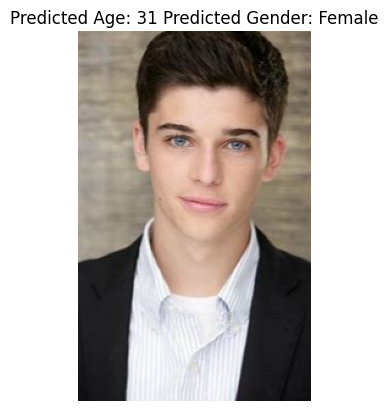

In [40]:
img_to_test = list(uploaded.keys())[0]
features = get_image_features(img_to_test)
pred = model.predict(features)
# Define gender_mapping dictionary
gender_mapping = {0: 'Male', 1: 'Female'}
gender = gender_mapping[round(pred[0][0][0])]
age = round(pred[1][0][0])

plt.title(f'Predicted Age: {age} Predicted Gender: {gender}')
plt.axis('off')
plt.imshow(np.array(load_img(img_to_test)))

Original Gender: Female Original Age: 12
1/1 [==============================] - 0s 52ms/step
Predicted Gender: Female Predicted Age: 16


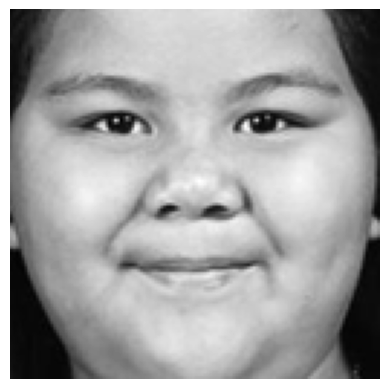

In [41]:
image_index = 10000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(x[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(x[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 60
1/1 [==============================] - 0s 18ms/step
Predicted Gender: Female Predicted Age: 54


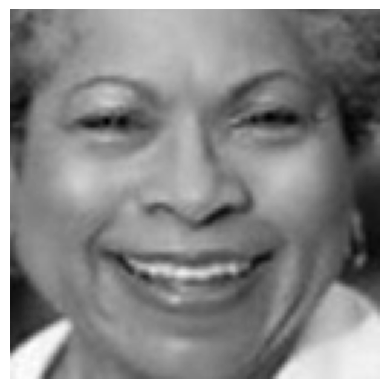

In [42]:
image_index = 30
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(x[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(x[image_index].reshape(128, 128), cmap='gray');